In [1]:
from sbhandler import *

In [4]:

def hot_encode(num):
    if num == 65: return 1
    elif num == 67: return 2
    elif num == 71: return 3
    elif num == 84: return 4
    else: return 5

def raw_hot_encode(num):
    if num == 65: return 0
    elif num == 67: return 1
    elif num == 71: return 2
    elif num == 84: return 3
    else: return 4
    
def update_bfp_trackers(bfp, tracking, conditional_error, deletions):
    cov = int((len(bfp.columns)-4)/2)
    for read_num in range(1, cov+1):
        read = bfp[f'read{read_num}']
        idx = truncate_start(read)
        end = truncate_end(read, idx)
        
        for nuc in range(idx, end):
            
            true_nuc = bfp.iloc[nuc,0]
            chr_tnuc = chr(true_nuc) # convert to a chr the targ
            qscore = bfp[f'q{read_num}'].iloc[nuc] # The qscore
            check = read.iloc[nuc]
            if qscore == 33:
                qscore = indel_qscore(bfp, read, nuc, cov)
                if isDel(bfp, nuc):
                    key = nuc_sandwich(read, nuc)
                    if key == 'None' or key not in list(deletions['A'][33].keys()): continue
                    deletions[chr_tnuc][qscore][key] += 1                   
            if check == true_nuc: # If correct. Add to observed
                # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                # tracking[chr_tnuc][qscore]['correct'] += 1
                tracking[chr_tnuc][qscore][0] += 1
            else: # If they disagree
                conditional_error[chr_tnuc][raw_hot_encode(check)] += 1
                tracking[chr_tnuc][qscore][hot_encode(check)] +=1
                
def update_rfp_trackers(rfp, tracking, conditional_error_red, deletions):
    cov = int((len(rfp.columns)-4)/2)
    if cov > 4:
        for read_num in range(1, cov+1):
            read = rfp[f'read{read_num}']
            true = rfp.loc[:, 'contig']
            idx = truncate_start(read)
            end = truncate_end(read, idx)
            for nuc in range(idx, end):
                true_nuc = true.iloc[nuc]
                chr_tnuc = chr(true_nuc) # convert to a chr the targ
                qscore = rfp[f'q{read_num}'].iloc[nuc] # The qscore
                check = read.iloc[nuc] # 
                
                if qscore == 33:
                    qscore = indel_qscore(rfp, read, nuc, cov)
                    if isDel(rfp, nuc, rfp=True):
                        key = nuc_sandwich(read, nuc)
                        if key == 'None' or key not in list(deletions['A'][33].keys()): continue
                        # print(chr_tnuc, qscore, key)
                        deletions[chr_tnuc][qscore][key] += 1
                
                if check == true_nuc: # If correct. Add to observed
                    # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                    # tracking[chr_tnuc][qscore]['correct'] += 1
                    tracking[chr_tnuc][qscore][0] += 1
                else: # If they disagree
                    # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct':0, 65:0,67:0,71:0,84:0,45:0})
                    # tracking[chr_tnuc][qscore][chr(check)] += 1
                    conditional_error_red[chr_tnuc][raw_hot_encode(check)] += 1
                    tracking[chr_tnuc][qscore][hot_encode(check)] +=1        
                    
def update_correct_wrong_rfp(rfp, red_counter):
    cov = int((len(rfp.columns)-4)/2)
    if cov > 4:
        for read_num in range(1, cov+1):
            read = rfp[f'read{read_num}']
            true = rfp.loc[:, 'contig']
            idx = truncate_start(read)
            end = truncate_end(read, idx)
            for nuc in range(idx, end):
                true_nuc = true.iloc[nuc]
                chr_tnuc = chr(true_nuc) # convert to a chr the targ
                qscore = rfp[f'q{read_num}'].iloc[nuc] # The qscore
                check = read.iloc[nuc] # 
                if qscore == 33:
                    # Time to test different ones.
                    continue
                
                if true_nuc != 45:
                    if true_nuc == check:
                        red_counter[chr_tnuc][qscore][0] += 1
                    else: 
                        red_counter[chr_tnuc][qscore][1] += 1

In [2]:
# load_matlab_file function Testing
file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

# DNA_seqs can be used to grab each raw_seqblock
DNA_seqs = DNA_SeqBlocks(h5py_object=h5py_object, data=data) 

FILE_SIZE = DNA_seqs.size #Constant

#### Load in barcodes 

In [18]:
# df = pickle.load(open('pickle/v2BarcodesTruelen.pickle', 'rb'))
# BARCODES = df.barcode
# TRUELENS = df.true_len

In [5]:
# Make sure it works on a small dataset first.
tinyDS = range(1, 10001)
DS = range(1, FILE_SIZE+1)

### Funcs to calculate `tracking` and figure out indels

In [6]:
# Functions made for 'Sequencing Error Rates' block
def truncate_start(read):
    idx = 0
    if len(read) > 2 and read.iloc[0] == 45: # if it starts with an indel
        idx = 1
        while (idx < len(read) and read.iloc[idx] == 45):
            # if (idx > 0 and idx % 100 == 0): print(bfp.index.name)\
            idx += 1
    return idx

def truncate_end(read, idx):
    len_read = len(read)
    end = len_read
    if len_read < 4: return end # Surprisingly this was needed.
    if (read[-3:] == [45, 45, 45]).all():
        end = len_read - 3
        while idx < (end) and read.iloc[end] == 45: # POTENTIAL BUG: Trying while idx < end, instead of idx < end - 1
            end -= 1
    return end
    
def indel_qscore(df, read, idx, cov): # to change
    return use_inverse_sum(df,read,idx,cov)
    
def use_inverse_sum(df, read, idx, cov):
    if idx +1 < len(read) and idx > 0:
        if cov < 10: the_number = read.name[-1]
        else: 
            try: the_number = int(read.name[-2:])
            except: the_number = read.name[-1]
        left = df[f'q{the_number}'].iloc[idx-1]
        right = df[f'q{the_number}'].iloc[idx+1]
        lidx = idx-2
        ridx = idx+2
        while lidx >= 0 and left == 33:
            left = df[f'q{the_number}'].iloc[lidx]
            lidx -= 1
        while ridx + 1 < len(read) and right == 33:
            right = df[f'q{the_number}'].iloc[ridx]
            ridx += 1
        return int(2*((1)/((1/left)+(1/right))))
    else: return 33

def nuc_sandwich(read, idx):
    if len(read) > idx + 1 and idx > 0:
        left = read.iloc[idx-1]
        right = read.iloc[idx+1]
        lidx = idx-2
        ridx = idx+2
        while lidx >= 0 and left == 45:
            left = read.iloc[lidx]
            lidx -= 1
        while ridx + 1 < len(read) and right == 45:
            right = read.iloc[ridx]
            ridx += 1
        left = chr(left)
        right = chr(right)
        return str(left+right)
    print(read, idx)
    return 'None'

def idx_del(read, idx):
    # initialize
    left = read.iloc[idx]
    right = read.iloc[idx]
    lidx = idx
    ridx = idx
    
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = read.iloc[lidx]
    while ridx + 1 < len(read) and right == 45:
        right = read.iloc[ridx]
        ridx += 1
    return lidx+1, ridx-1 # gives the exact .iloc[] of where the deletions are

def idx_ins(df, idx, rfp=False): #same inner mechanics as idx_del but uses target to find 
    if rfp:
        return idx_del(df['contig'], idx)
    return idx_del(df['target'], idx)

def get_trunc_range(read):
    idx = truncate_start(read)
    end = truncate_end(read, idx)
    return range(idx, end)
    

### Funcs to Classify Indel Types

In [7]:
def get_cov(df): return int((len(df.columns)-4)/2)

def get_yBlock(df, read, idx, rfp=False): pass

def isFalseInDel(df, read, idx, rfp=False, conditional = False): # Done. Checks target and read to see if they are both indels
    if conditional:
        if df.iloc[idx] == 45 and read.iloc[idx] == 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] == 45 and read.iloc[idx] == 45: return True
        return False
    if df['target'].iloc[idx] == 45 and read.iloc[idx] == 45: return True
    return False
# Which major yyy conflict?
def isDel(df, read, idx, rfp=False, conditional=False): # Checks if targ doesn't have an indel where the read has one.
    if conditional:
        if df.iloc[idx] != 45 and read.iloc[idx] == 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] != 45 and read.iloc[idx] == 45: return True
        return False
    if df['target'].iloc[idx] != 45 and read.iloc[idx] == 45: return True
    return False

def isIns(df, read, idx, rfp=False, conditional=False): # Checks if targ has an indel where a read has a NUC.
    print('Use isDel')
    if conditional:
        if df.iloc[idx] == 45 and read.iloc[idx] != 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] == 45 and read.iloc[idx] != 45: return True
        return False
    if df['target'].iloc[idx] == 45 and read.iloc[idx] != 45: return True
    return False
# Single or Multi?
def isSingleDel(read, idx): # Checks if read has only one indel.
    if read.iloc[idx+1] != 45 and read.iloc[idx-1] != 45: return True
    return False

def isSingleIns(df, idx, rfp=False, conditional=False): # Checks if target has only one indel.
    if conditional:
        if df.iloc[idx+1] != 45 and df.iloc[idx-1] != 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx+1] != 45 and df['contig'].iloc[idx-1] != 45: return True
        return False
    if df['target'].iloc[idx+1] != 45 and df['target'].iloc[idx-1] != 45: return True
    return False
# How big is the Multi? (False^)
def countDel(read, idx): # Retruns the count of dels in a multiple deletion
    count = 1
    left = read.iloc[idx-1]
    right = read.iloc[idx+1]
    lidx = idx
    ridx = idx
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = read.iloc[lidx]
        if left == 45: count += 1
    while ridx + 1 < len(read) and right == 45:
        ridx += 1
        right = read.iloc[ridx]
        if right == 45: count += 1
    return count

def countIns(targ, idx): # Returns the count of ins in a multi ins.
    count = 1
    left = targ.iloc[idx-1]
    right = targ.iloc[idx+1]
    lidx = idx
    ridx = idx
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = targ.iloc[lidx]
        if left == 45: count += 1
    while ridx + 1 < len(targ) and right == 45:
        ridx += 1
        right = targ.iloc[ridx]
        if right == 45: count += 1
    return count
# Concord vs. Discord Del classification 
def isConcordDel(read, idx): # use the sacred nuc_sandwich
    sides = nuc_sandwich(read, idx)
    if sides[0] == sides[1]: return True
    return False
# Known Concord
def isConcord1Del(df, read, idx, rfp=False, count=1):
    to_check = nuc_sandwich(read,idx)[0]
    
    #MultiDels
    if count > 1:
        lidx, ridx = idx_del(read, idx)
        same = 0
        for idx in range(lidx, ridx+1):
            if rfp:
                if df['contig'].iloc[idx] != to_check: continue
                else: same += 1
            else:
                if df['target'].iloc[idx] != to_check: continue
                else: same += 1
        return same
    
    #SingleDels
    if rfp:
        if df['contig'].iloc[idx] == to_check: return True
        return False
    if df['target'].iloc[idx] == to_check: return True
    return False

def isConcord0Del(): print('Use isConcord1Del')

def isDiscordDel():  print('Use isConcordDel')

def isDiscord1Del(df, read, idx, rfp=False, count=1):
    to_check = nuc_sandwich(read,idx)
    check_left = to_check[0]
    check_right = to_check[1]
    
    #MultiDels
    if count > 1:
        lidx, ridx = idx_del(read, idx)
        lsame = 0
        rsame = 0
        if rfp:
            targ = df['contig']
        else:
            targ = df['target']
        for idx in range(lidx, ridx+1):
            if targ.iloc[idx] == check_left: lsame += 1
            elif targ.iloc[idx] == check_right: rsame += 1
            else: continue
        return lsame, rsame
    
    #SingleDels
    if rfp:
        if df['contig'].iloc[idx] == check_left or df['contig'].iloc[idx] == check_right: return True
        return False
    else:
        if df['target'].iloc[idx] == to_check or df['target'].iloc[idx] == check_right: return True
        return False

def isDiscord0Del():print('Use is Discord1Del')
# Concord vs. Discord Ins classification
def isConcordIns(df, idx, rfp=False): # use nuc_sandwich on target
    if rfp:
        to_check = nuc_sandwich(df['contig'], idx)
    else:
        to_check = nuc_sandwich(df['target'], idx)
    if to_check[0] == to_check[1]: return True
    return False        
# True ^
def isConcord1Ins(df, read, idx, rfp=False, count=1):
    if rfp:
        sandwich = nuc_sandwich(df['contig'], idx)
    else:
        sandwich = nuc_sandwich(df['target'], idx)
    to_check = sandwich[0]
    
    if count > 1:
        same = 0
        lidx, ridx = idx_ins(df, idx, rfp)
        
        for idx in range(lidx, ridx+1):
            if read.iloc[idx] == to_check: same += 1
        return same
    
    if read.iloc[idx] == to_check: return True
    return False

def isConcord0Ins(): print('use isConcord1Ins')

def isDiscordIns(): print('Use isConcordIns')

def isDiscord1Ins(df, read, idx, rfp=False, count=1):
    if rfp:
        to_check = nuc_sandwich(df['contig'],idx)
    else:
        to_check = nuc_sandwich(df['target'], idx)
    check_left = to_check[0]
    check_right = to_check[1]
    
    #MultiIns
    if count > 1:
        if rfp:
            lidx, ridx = idx_del(df['contig'], idx)
        else:
            lidx, ridx = idx_ins(df['target'], idx)
        lsame = 0
        rsame = 0
        
        for idx in range(lidx, ridx+1):
            if read.iloc[idx] == check_left: lsame += 1
            elif read.iloc[idx] == check_right: rsame += 1
            else: continue
            
        return lsame, rsame
    
    #SingleDels
    if read.iloc[idx] == check_left or read.iloc[idx] == check_right: return True
    return False

def isDiscord0Ins(): print('Use isDiscord0Ins')


In [8]:
tracking = pickle.load( open('pickle/v2TrackingwRFP.pickle', 'rb'))

In [1]:
import pickle
bfp_list = pickle.load( open('pickle/raw_bfp.pickle', 'rb'))
rfp_list = pickle.load( open('pickle/raw_rfp.pickle', 'rb'))

### How many single, secondary, tertiary coverage BFP reads (known) have supposed mutations?

Observation: Most of them are due to single insertions (concluded as true). Some are due to absolutely terrible reads (esp. cov 1)

In [32]:
bfp1cov = []
bfp2cov = []
bfp3cov = []

for bfp in bfp_list:
    cov = get_cov(bfp)
    if cov == 1:
        bfp1cov.append(bfp)
    elif cov == 2:
        bfp2cov.append(bfp)
    elif cov == 3:
        bfp3cov.append(bfp)
    else: continue

for l in [bfp1cov, bfp2cov, bfp3cov]:
    with_muts = 0
    for b in l:
        mut_count = b[b['mutations'] != 32]
        mut_count = len(mut_count)
        if mut_count != 0:
            # print(b.index.name)
            with_muts += 1
    print(f'{100*with_muts/len(bfp1cov):.2f}%')



        
        
        

23.95%
5.47%
1.83%


### Get: list of bfp/rfp with YYY conflicts

In [9]:
bfp_with_y = []
yconflict = []
rfp_with_y = []

for bfp in bfp_list:
    if bfp.empty: continue
    to_add = bfp[bfp['changes'] == 121]
    if to_add.empty: continue
    else:
        bfp_with_y.append(bfp)
        yconflict.append(to_add)
        
for rfp in rfp_list:
    if rfp.empty: continue
    to_add = rfp[rfp['changes'] == 121]
    if to_add.empty: continue
    else:
        rfp_with_y.append(rfp)
        yconflict.append(to_add)

## Bottleneck: Test different get_indel_qscore() to create a more linear OBSERVED_QSCORE
-------------------------------------------------------------

In [36]:
def indel_qscore(df, read, idx, cov): # to change
    return use_inverse_sum(df,read,idx,cov)

def get_lr(df, read, idx, cov):
    if idx +1 < len(read) and idx > 0:
        if cov < 10: the_number = read.name[-1]
        else: 
            try: the_number = int(read.name[-2:])
            except: the_number = read.name[-1]
            
        left = df[f'q{the_number}'].iloc[idx-1]
        right = df[f'q{the_number}'].iloc[idx+1]
        lidx = idx-2
        ridx = idx+2
        while lidx >= 0 and left == 33:
            left = df[f'q{the_number}'].iloc[lidx]
            lidx -= 1
        while ridx + 1 < len(read) and right == 33:
            right = df[f'q{the_number}'].iloc[ridx]
            ridx += 1
        return left, right    
    return -1, -1

def use_inverse_sum(df, read, idx, cov):
    left, right = get_lr(df, read, idx, cov)
    if left != -1:
        return int(2*((1)/((1/left)+(1/right))))
    else: 
        return 33
    
def use_min(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.min([l, r])
    return 33

def use_max(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.max([l, r])
    return 33

def use_geo_mean(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.sqrt(l*r)
    return 33

def use_arith_mean(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.mean([l, r])
    return 33


### GET: counter of indel types in bfp_with_y (list from above)

In [ ]:
# Counters
del_counter = dict(zip(['single', 'c1', 'c0', 'd1', 'd0', 'multi'], [0]*6))
ins_counter = del_counter.copy()

multi_del_specs = dict(zip([i for i in np.arange(2, 22), [0]*20))
multi_ins_specs = multi_del_specs.copy()


# conc_insert = dict(zip(['*A', 'A*', '*C', 'C*', '*G', 'G*', 'T*', '*T'], [ [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3] ]))
# disc_inset = dict(zip(['*AC', ]))

conc_insert = dict(zip(['A', 'C', 'G', 'T',], [ [[[0]]*3], [[[0]]*3], [[[0]]*3], [[[0]]*3] ]))
disc_insert = dict(zip(['AC'], [[[0]]*3]))

In [ ]:
for bfp in bfp_with_y[::50]:
    focus = bfp[bfp['changes']==121]
    targ = focus['target']
    cov = get_cov(bfp)
    
    for read_num in range(1, cov+1):
        
        read = focus[f'read{read_num}']
        truncate_start = True
        
        for idx in range(len(read)): # .iloc[] depends on focus
            
            # Special block to skip misaligned start
            if idx == len(read) - 1: continue
            
            if truncate_start:
                if read.iloc[idx] != 45: 
                    truncate_start = False
                    continue
                else:
                    continue            
            
            ### DELETIONS
            qscore = focus[f'q{read_num}'].iloc[idx]
            if qscore == 33: # So is it a DEL or a fake?

                if isFalseInDel(focus, read, idx): continue
                
                ## Single DELS
                if isSingleDel(read, idx): 
                    del_counter['single'] += 1
                    if isConcordDel(read, idx):
                        # if isConcord1Del(focus, read, idx):
                        if targ.iloc[idx-1] == targ.iloc[idx+1] and targ.iloc[idx] == targ.iloc[idx-1]:
                            print("Tf?")
                            del_counter['c1'] += 1
                        else: del_counter['c0'] += 1
                    else:
                        if isDiscord1Del(focus, read, idx):
                            del_counter['d1'] += 1
                        else: del_counter['d0'] += 1
                        
                ## MULTI DELS
                else:
                    del_counter['multi'] += 1
                    count = countDel(read, idx)
                    if count not in multi_del_specs.keys(): 
                        out_multi_del[count] = bfp.index.name
                        continue
                    multi_del_specs[count] += 1
                    
                    
                    
                    
            ### INSERTIONS
            if targ.iloc[idx] == 45: # Insert or fake?
                if isFalseInDel(focus, read, idx): continue
                
                
                ## SINGLE INSERTS
                if isSingleIns(focus, idx):
                    
                    num_insert = read.iloc[idx]
                    
                    ins_counter['single'] += 1
                    if isConcordIns(focus, idx):
                        # if isConcord1Ins(focus, read, idx):
                        
                        # CONCORD 1 INSERT
                        if targ.iloc[idx-1] == targ.iloc[idx+1] and read.iloc[idx] == targ.iloc[idx-1]:
                            # print("ins tf?")
                            ins_counter['c1'] +=1
                            
                            if chr(num_insert) not in conc_insert.keys(): conc_insert[chr(num_insert)] = [[0]]*3
                            qscores = list() //////////////?TODO
                            
                            
                        # CONCORD 0 INSERT
                        else: 
                            ins_counter['c0'] +=1
                            
                            
                    else:
                        if targ.iloc[idx-1] == read.iloc[idx] or targ.iloc[idx+1] == read.iloc[idx]:
                            # print("um")
                            ins_counter['d1'] +=1 
                        else:
                            ins_counter['d0'] +=1
                            
                            
                ## MULTI INSERTS
                else:
                    ins_counter['multi'] += 1
                    count = countIns(targ, idx)
                    if count not in multi_del_specs.keys(): 
                        out_multi_ins[count] = bfp.index.name
                        continue
                    multi_ins_specs[count] += 1
                        
del_counter, ins_counter,  multi_del_specs, multi_ins_specs
                        
                    

### EXPLORE: Indels in RFP (mutation). Observe in high cov

In [106]:
def each_read(original_df):
    """Returns list of all reads for a df

    Args:
        original_df (_type_): _description_

    Returns:
        _type_: _description_
    """
    cov = get_cov(original_df)
    each_read = []
    for read_num in range(1, cov+1):
        each_read.append(original_df[f'read{read_num}'])
    return each_read
    

def repeat_block(original_df, nuc, idx):
    """Insertion confirmed. 
    Returns size of repeat block with the nucleotide
    """
    insert = nuc
    label_idx = (read.index[idx])
    
    repeat_size = 1 # insert
    
    left_iter = label_idx - 1
    right_iter = label_idx + 1
    
    left_bound = original_df.index[0]
    right_bound = original_df.index[-1]
    
    mod_read = original_df[read.name]
    curr = mod_read
    
    keep_checking = True
    right_check = True

    while left_iter > left_bound and keep_checking:
        
        read_nuc = curr.loc[left_iter]
        
        if read_nuc == insert: 
            repeat_size += 1
            left_iter -= 1
            
        elif read_nuc != 45:
            # Maybe? 
            # Check all other reads?
            #
            keep_checking = False
            break
        
        else:
            for r in each_read(original_df):
                if r.loc[left_iter] == insert:
                    curr = r
                    left_iter -= 1
                    repeat_size += 1
                    # print(left_iter)
                    break
            # print(left_iter)
            # check beyond the indel if none of the previous ones worked
            for r in each_read(original_df):
                if r.loc[left_iter-1] == insert:
                    curr = r
                    left_iter -= 2
                    repeat_size += 1
                    break
    
    curr = mod_read
    
    while right_iter < right_bound and right_check:
        read_nuc = curr.loc[right_iter]
        
        if read_nuc == insert: 
            repeat_size += 1
            right_iter += 1
            
        elif read_nuc != 45:
            # Maybe? 
            # Check all other reads?
            #
            right_check = False
            break
        
        else:
            for r in each_read(original_df):
                if r.loc[right_iter] == insert:
                    curr = r
                    right_iter += 1
                    repeat_size += 1
                    break
            # check beyond the indel if none of the previous ones worked
            for r in each_read(original_df):
                if r.loc[right_iter+1] == insert:
                    curr = r
                    right_iter += 2
                    repeat_size += 1
                    break
    return repeat_size
    # What is the insertion nucleotide? 
    # Convert read.loc[idx] to a label idx to enter original_df
    # Count left and right. Stop at a diff nucleotide. If an indel is found, check other reads for a nucleotide, otherwise check target and continue from there.

In [110]:
# Is an insertion ever a valid mutation?
# . Let's look at RFP with cov > 5

for rfp in rfp_with_y:
    focus = rfp[rfp['changes']==121] # look only at the places with yyy 
    targ = focus['contig']
    og = focus['target']
    cov = get_cov(rfp)
    if cov < 4: continue
    
    truncate_start = True
    for idx in range(len(focus)):
        # per nucleotide
        first_repeat_size_check = True
        
        check_turn_off_truncater = 0
        
        nuc_del_count = 0
        nuc_ins_count = 0
        for r in each_read(focus):
            print(truncate_start)
            # Special block to skip misaligned reads
            if idx == len(read) - 1: continue # an indel at the end is useless
            
            if truncate_start:
                if r.iloc[idx] != 45: 
                    check_turn_off_truncater += 1
                    if check_turn_off_truncater == cov:
                        truncate_start = False
                else: # skip the read that has indels at the start  
                    continue
            
            #Cleaned sequence
            
        if og.iloc[idx] == 45 and targ.iloc[idx] != 45: # An insertion that is supposedly true mutatio
            print(repeat_block(rfp, targ.iloc[idx], idx))
                
               
                    

True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
F

KeyboardInterrupt: 

In [ ]:
# For each qscore (except 32): track value[0] observed, value[1] incorrect
each_qscore = {'correct' : 0, 'A' : 0, 'C' : 0, 'G' : 0, 'T' : 0, '-' : 0}

deletions = {'A' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(33, 127) },
             'C' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(33, 127) },
             'G' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(33, 127) },
             'T' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(33, 127) }}

tracking = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}

conditional_error = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))


conditional_error_red = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))
deletions_red = { 'A' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
              'C' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
              'G' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
              'T' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) }}


In [ ]:
for bfp in bfp_list:
    if bfp.empty: continue
    update_bfp_trackers(bfp, tracking, conditional_error, deletions)            

for rfp in rfp_list:
    if rfp.empty: continue
    update_rfp_trackers(rfp, tracking, conditional_error_red, deletions_red)

In [178]:
red_counter = dict(zip(['A', 'C', 'T', 'G'], [{i : [0,0] for i in np.arange(34, 127)}]*5))

for rfp in rfp_list:
    if rfp.empty: continue
    update_correct_wrong_rfp(rfp, red_counter)
                    

In [43]:
A = pd.DataFrame(deletions['A'])
C = pd.DataFrame(deletions['C'])
G = pd.DataFrame(deletions['G'])
T = pd.DataFrame(deletions['T'])
df = A + C + G + T

Frequency of specific deletions. Assume order has no uniqueness

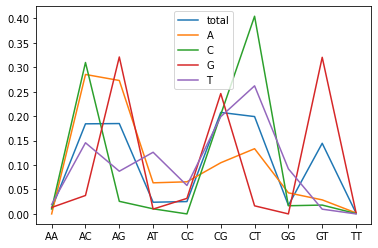

In [56]:
import matplotlib.pyplot as plt
raw_x = np.arange(32, 127)
def plot_del_freq(A, nuc):
    Arec = A.sum(axis=1)
    total = Arec.sum()
    to_see = list(Arec.index)
    temp = list(Arec.index)

    to_see = Arec.index
    for i in temp:
        for j in to_see:
            if i == j: continue
            if (i == j[::-1]): 
                Arec[i] += Arec[j]
                Arec = Arec.drop(j)
                temp.remove(j)
                to_see.drop(j)
    plt.plot(Arec.index, Arec/total, label=nuc)
    return Arec

plot_del_freq(df, "total")
plot_del_freq(A, 'A')
plot_del_freq(C, 'C')
plot_del_freq(G, 'G')
plot_del_freq(T, 'T')
plt.legend(loc='best')



Assume ordering is unique.

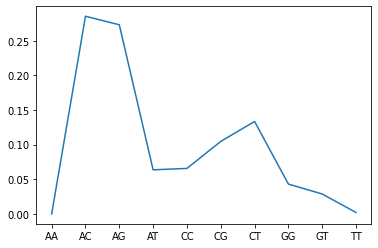

In [48]:
def plot_del_freq(A):
    Arec = A.sum(axis=1)
    total = Arec.sum()
    to_see = list(Arec.index)
    temp = list(Arec.index)

    to_see = Arec.index
    for i in temp:
        for j in to_see:
            if i == j: continue
            if (i == j[::-1]): 
                Arec[i] += Arec[j]
                Arec = Arec.drop(j)
                temp.remove(j)
                to_see.drop(j)
    plt.plot(Arec.index, Arec/total)


### Correcting Q Score

In [92]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y

In [94]:
for nuc in to_plot:
    focus = to_plot[nuc]
    for n, num in enumerate(focus):
        focus[n] = 33 - (10 * np.log10(num))

Text(0, 0.5, 'Observed Q Score')

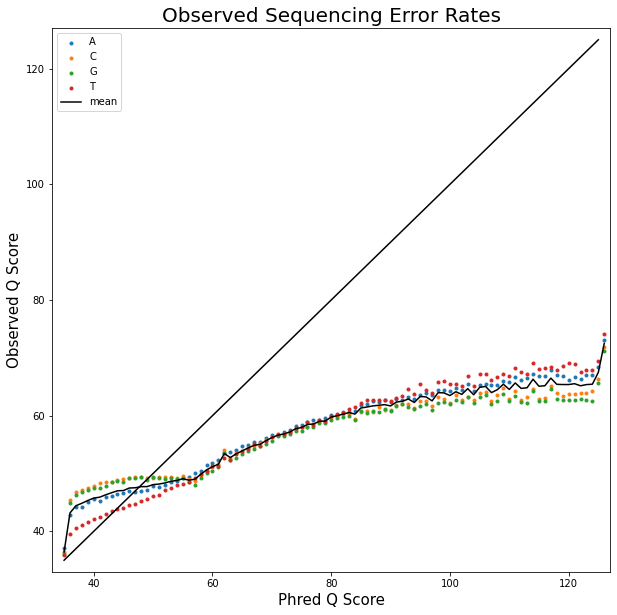

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for nuc in to_plot:
    plt.scatter(raw_x, to_plot[nuc], marker='.', label=nuc)
plt.plot(raw_x, (pd.DataFrame(to_plot).mean(axis=1).values), color='k', label="mean")

plt.plot(np.arange(35, 126), np.arange(35, 126), color='k')
plt.legend()
plt.xlim([33, 127])
plt.ylim([33, 127])
plt.title('Observed Sequencing Error Rates', fontsize=20)
plt.xlabel('Phred Q Score', fontsize=15)
plt.ylabel('Observed Q Score', fontsize=15)


/tmp/ipykernel_1840435/1095344616.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AC)))
/tmp/ipykernel_1840435/1095344616.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AG)))
/tmp/ipykernel_1840435/1095344616.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AT)))
/tmp/ipykernel_1840435/1095344616.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AI)))


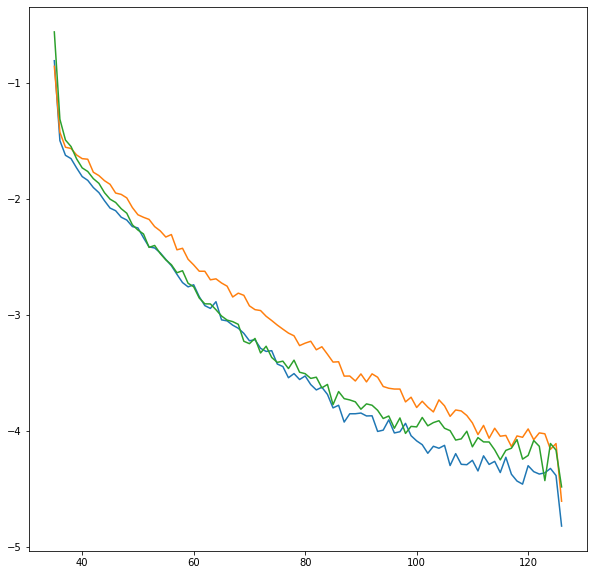

In [186]:
test = []
AT = []
AC = []
AG = []
AI = []

for q, freq in tracking['A'].items():
    test.append(q)
    total = freq[0]
    check = freq[2:]
    for idx, num in enumerate(check):
        if idx == 0:
            if total == 0: AC.append(0)
            else: AC.append(num/total)
        elif idx == 1:
            if total == 0: AG.append(0)
            else: AG.append(num/total)
        elif idx == 2:
            if total == 0: AT.append(0)
            else: AT.append(num/total)
        elif idx == 3:
            if total == 0: AI.append(0)
            else: AI.append(num/total)
        else: print(f"?{q} {idx} {num}")
plt.figure(figsize=(10,10))
plt.plot(test, list(map(np.log10, AC)))
plt.plot(test, list(map(np.log10, AG)))
plt.plot(test, list(map(np.log10, AT)))
plt.plot(test, list(map(np.log10, AI)))

    

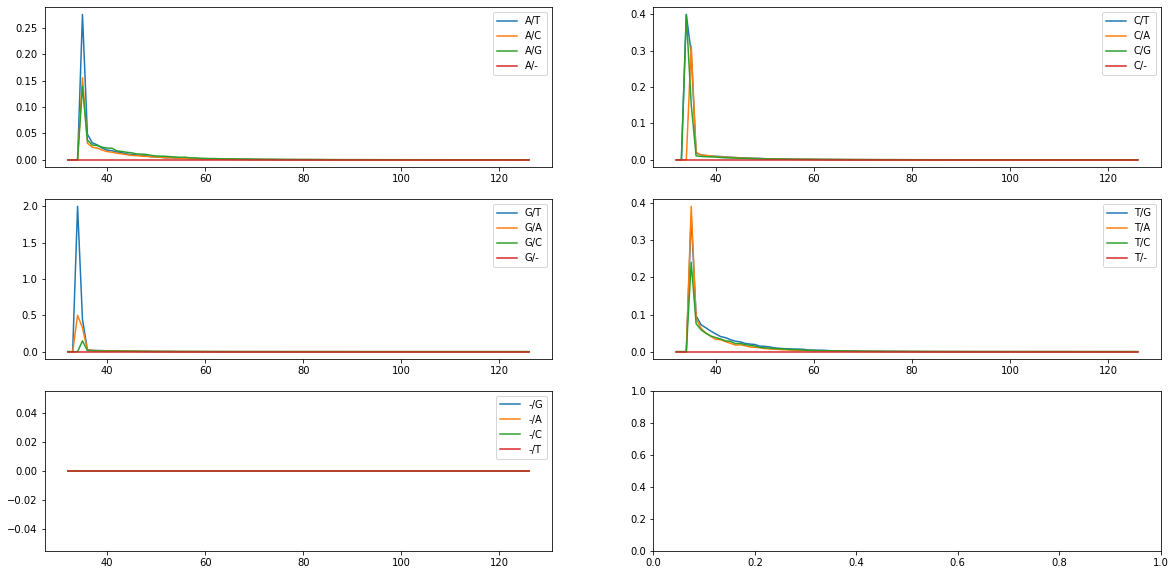

In [183]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
skip = {'A':0, 'C':1, 'G':2, 'T':3, '-':4}

for nuc in ['A', 'C', 'G', 'T', '-']:
    test = []
    AT = []
    AC = []
    AG = []
    AI = []

    for q, freq in tracking[nuc].items():
        test.append(q)
        total = freq[0]
        check = freq[1:]
        check.pop(skip[nuc])
        for idx, num in enumerate(check):
            if idx == 0:
                if total == 0: AC.append(0)
                else: AC.append(num/total)
            elif idx == 1:
                if total == 0: AG.append(0)
                else: AG.append(num/total)
            elif idx == 2:
                if total == 0: AT.append(0)
                else: AT.append(num/total)
            elif idx == 3:
                if total == 0: AI.append(0)
                else: AI.append(num/total)
            else: continue
    if nuc =='A':
        axes[0,0].plot(test, AT, label = 'A/T')
        axes[0,0].plot(test, AC, label = 'A/C')
        axes[0,0].plot(test, AG, label = 'A/G')
        axes[0,0].plot(test, AI, label = 'A/-')
        axes[0,0].legend()
    elif nuc =='C':
        axes[0,1].plot(test, AT, label = 'C/T')
        axes[0,1].plot(test, AC, label = 'C/A')
        axes[0,1].plot(test, AG, label = 'C/G')
        axes[0,1].plot(test, AI, label = 'C/-')
        axes[0,1].legend()
    elif nuc =='G':
        axes[1,0].plot(test, AT, label = 'G/T')
        axes[1,0].plot(test, AC, label = 'G/A')
        axes[1,0].plot(test, AG, label = 'G/C')
        axes[1,0].plot(test, AI, label = 'G/-')
        axes[1,0].legend()
    elif nuc == 'T':
        axes[1,1].plot(test, AT, label = 'T/G')
        axes[1,1].plot(test, AC, label = 'T/A')
        axes[1,1].plot(test, AG, label = 'T/C')
        axes[1,1].plot(test, AI, label = 'T/-')
        axes[1,1].legend()
    else:
        axes[2,0].plot(test, AT, label = '-/G')
        axes[2,0].plot(test, AC, label = '-/A')
        axes[2,0].plot(test, AG, label = '-/C')
        axes[2,0].plot(test, AI, label = '-/T')
        axes[2,0].legend()


In [6]:
tracking = pickle.load( open('pickle/v2TrackingwRFP.pickle', 'rb'))

### Plotting Nucleotide-specific Error Patterns

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
skip = {'A' : 0, 'C' : 1, 'G': 2, 'T': 3}
associate = {0 : 'A', 1: 'C', 2: 'G', 3: 'T'}

x = [i for i in np.arange(33, 126)]
for nuc in ['A']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 45: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'C', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:
x = [i for i in np.arange(39, 126)]
for nuc in ['C']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:

for nuc in ['G']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')  
        plt.tight_layout()

In [ ]:
for nuc in ['T']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'G'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')

### VISUALIZE: Real Error of z and yyy

#### Z Conflicts

- Currently: Plot total wrong / all instances of reads vs true
- Line of best fit plotted at Q > 45


In [248]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y




Take the log if non-zero. Motive: linear graph

In [254]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

for nuc in ['A', 'C', 'G', 'T']:
    to_change = to_plot[nuc]
    for i in range(len(to_change)):
        if to_change[i] == 0: 
            to_change[i] = 0 
        else: 
            to_change[i] = math.log(to_change[i])


Fill in missing values with a mean (only present at low sample sizes)

In [80]:
for nuc in ['A', 'C', 'G', 'T']:
    fix = to_plot[nuc]
    for i in range(len(fix)):
        if fix[i] == 0:
            fix[i] = 0.5*(fix[i-1]+fix[i+1])

Plot the 4 nucleotides 

In [ ]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

axes[0,0].scatter(raw_x, to_plot['A'], c='red',s=12)
axes[0,1].scatter(raw_x, to_plot['C'], c='blue', s=12)
axes[1,0].scatter(raw_x, to_plot['G'], c='green',s=12)
axes[1,1].scatter(raw_x, to_plot['T'], c='purple',s=12)

# Needs to be calculated below
# axes[0,0].scatter(x, lobA, c='black')
# axes[0,1].scatter(x, lobC, c='black')
# axes[1,0].scatter(x, lobG, c='black')
# axes[1,1].scatter(x, lobT, c='black')

# # Check something...
# for i in range(2):
#     for j in range(2):
#         axes[i,j].hlines(0.01, 35, 126)

labels = ['A', 'C', 'G', 'T']
# labels_with_lobf = ['A', '_lobfA', 'C', '_lobfC',  'G', '_lobfG',  'T', '1e-2']
fig.legend(labels=labels, loc="right")
fig.suptitle('Associating Error Rate with Phred Q Score (n=455,157)', fontsize=25)
fig.supxlabel('Phred Q scores', fontsize=20)
fig.supylabel('Log_10 Adjusted Real Error Rate', fontsize=20)
# fig.supylabel('Real Error Rate', fontsize=20)





In [242]:
# count = 0
# for rfp in rfp_list:
#     if int((len(rfp.columns)-4)/2) > 3:
#         count += 1
# count

100053

### Line of best fits
- Calculated using ML and after Q = 45


In [94]:
# Assessing if contig is a viable thing to use for RFP Truth
for x,rfp in enumerate(rfp_list):
    if DNA_seqs.get_coverage_count(x+1) > 3:
        if rfp.empty: continue
        muts = rfp['changes']
        if len(muts[muts==122]) > 1:
            print(x+1)
            break

59


Using torch to calculate line of best fit

In [168]:
# Desired func y = mx + b => # params are m, b
import torch
p = torch.randn(2).requires_grad_()

In [169]:
x = torch.tensor(np.arange(46, 127)).long()
yA = torch.tensor(to_plot['A'][11:]).float()
yC = torch.tensor(to_plot['C'][11:]).float()
yG = torch.tensor(to_plot['G'][11:]).float()
yT = torch.tensor(to_plot['T'][11:]).float()

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x,self.y = x,y
        self.len = len(x)
        
    def __len__(self): return self.len
    
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

testdsA = torch.utils.data.DataLoader(Dataset(x,yA), batch_size=3)
testdsC = torch.utils.data.DataLoader(Dataset(x,yC), batch_size=5)
testdsG = torch.utils.data.DataLoader(Dataset(x,yG), batch_size=5)
testdsT = torch.utils.data.DataLoader(Dataset(x,yT), batch_size=5)

In [ ]:
def func(params, input):
    a, b = params
    return a*input + b

import torch.functional as F
from fastai.vision.all import *
from fastbook import *

def loss_func(pred, targ):
    # Let's use RMSE
    return ((pred-targ)**2).sqrt()

lr = 1e-5
for i in range(1000):
    loss_total = 0
    n_obs = 0
    for xin, yin in testdsT:
        
        pred = func(p, xin)
        loss = loss_func(pred, yin).mean()
        
        loss.backward() 
        p.data -= p.grad.data * lr
        p.grad = None
        
        n = len(xin)
        loss_total += loss.item()*n
        n_obs +=n
        
    print(loss_total/n_obs)

In [178]:
def f(x):
    a,b =p.data
    return a*x+b

In [183]:
lobT = []
for i in x:
    lobT.append(f(i))

#### YYY Conflicts

- Two main categories:
    - Insertion (Target, non-agreeing reads have '-' for alignment)
    - Deletion  (Only read has '-' for alignment) 

&nbsp;


- Insertion types:
    - Misaligned multi-insertions 
        - e.g. aligned as G-GG-AG / G**G**G*A*GAG when it should be GGG--AG / GGG**AG**AG) 
    - Multi-insertions (G--G / GAAG)
        - [4y+]
    - **Harmonious** Insert
        - Matches left AND right
    - **1x Discord** Insert
        - Matches left OR right nuc
    - **2x Discord** Insert
        - No match with left OR right
<br>      
&nbsp;
- Deletion types: (Note: the thing that *matches* is the truth that was deleted)
    - **Harmonious** del
        - Matches left AND right nuc
    - **1X Discord** del 
        - Matches left OR right nuc 
    - **2x Discord** del 
        - No match with left OR right [e.g. A-G when others say A**C**G]

Checking Difference in Error Counts between Nucleotides
- Not shown: spikes at Q=126
    - A ~ 20,000; C,G ~ 18,000; T ~ 10,000

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
tracking['A']

for nuc in ['A', 'C', 'G', 'T']:
    error_frequency = []
    for q, v in tracking[nuc].items():
        if q > 34:
            error_frequency.append(sum(v[1:]))
    q_related = [x for x in np.arange(35, 126)]
    plt.plot(q_related, error_frequency[:-1])
    # print(np.argmax(error_frequency[:-1]), max(error_frequency[:-1]))
    # print(error_frequency[2])
plt.legend(labels=['A', 'C', 'G', 'T'])
plt.ylabel('Error Count')
plt.xlabel('Phred Quality Score')
    # max_freq = max(error_frequency[:-1])
    # norm = [item/max_freq for item in error_frequency[:-1]]
    # plt.plot(q_related, norm)
    # plt.text(126, error_frequency[-1]-20_000, "%d" %error_frequency[-1] + nuc, ha="right")

&nbsp;

**Resolution**
- No Q score difference:
    - (! is an insert) \~\~\~ vs. ~!~ => \~\~\~ wins


In [ ]:
# Search for where there are y conflicts (once the first y is found. Keep checking "changes" column along nuc++ until a non-y char is found)
# Return the view of BFP or RFP with the continuous chunk of y's

def is_insertion(df):
    if (df['targ'][df['targ'] == 45]).empty: # If the target has NO indels
        return True # Means it's a INSERTION
    return False

def is_harmonious(df, coverage):
    for num in range(1, coverage+1):
        read = df[f'read{num}']
         
    

## Training a LogReg model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZConflicts(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        pass
        
class LinReg(nn.Module):
    
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        pass
        